In [23]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from spikelib.utils import check_directory
%matplotlib notebook

# Functions to get and plot features

In [31]:
def get_features(sorting, isi_bin=2):
    """
    Make array with general information about a sorting.
    
    Return m features for each unit, spikerate, isi peak.
    
    Paramters
    ---------
    sorting: h5py.Group
        root group of soprting hdf5 file.
    isi_bin: int
        bin size to get isi values
    
    Return
    ------
    Array with nxm, where n is the number of units and m is number
    of features.
    """
    features = np.zeros((len(sorting['/spiketimes']), 2))
    duration = sorting['/info/duration/'][...]
    bins = np.linspace(0, isi_bin*100, 101)
    isi = np.zeros((len(sorting['/spiketimes']), bins.shape[0]-1))
    list_key = []
    for kidx, key in enumerate(sorting['/spiketimes']):
        list_key.append(key)
        spk = sorting['/spiketimes'][key][...].flatten()
        features[kidx, 0] = spk.size/duration.astype(float)
        dff = np.diff(spk) if spk.any() else 0
        count, bins = np.histogram(dff, bins=bins)

        isi[kidx] = count
        features[kidx, 1] = np.argmax(count)*isi_bin
    isi_df = pd.DataFrame(data=isi, index=list_key, columns=bins[:-1].astype(int))
    return features, isi_df


def plot_raster(sorting, range_view=None, idx_units=None, protocols_points=None, sr=20000.0, **kwargs):
    """Create a raster figure of a range of units.
    
    Parameters
    ----------
    sorting: h5py.Group
        oot group of soprting hdf5 file.
    range_view: tuple, defaul None
        range of unit index to plot. example (100,200)
    idx_units: list(int)
        index of units to plot raster.
    protocols_points: list, default None
        set of point to draw when the protocols was showed.
    sr: flaot, defaul 20000.0
        sampling rate
        
    Return
    ------
    fig: figure
        matplotlib figure object
    ax: Axis
        matplotlib axis object

    """
    sr = float(sr)
    protocols_points = np.asarray(protocols_points)
    protocols_points = protocols_points if protocols_points.any() else []
    
    if not idx_units:
        keys = list(sorting['/spiketimes'])[range_view[0]:range_view[1]]
    else:
        keys = ['temp_{:d}'.format(key) for key in idx_units]
    

    fig, ax = plt.subplots(**kwargs)
    for kidx, key in enumerate(keys):
        spk = sorting['spiketimes'][key][...]/sr
        ax.plot(spk, np.full(spk.shape, kidx), marker='|',alpha=0.1)
    ax.set_title('raster')
    ax.set_xlabel('time')
    ax.set_ylabel('units')
    
    for ktime in protocols_points:
        ax.vlines(ktime/sr, 0, len(keys), color='k', lw=1, alpha=0.3)
        
    return fig, ax

# Data acquisition

In [25]:
exp_name = 'MR-0118'
sorting_path = '../../data/sorting/MR-0118.result_modified.hdf5'
sync_path = '../../data/sync/event_list_MR-0118.csv'
fig_path = '../../reports/fig/sorting_features/'

check_directory(fig_path)

In [26]:
sync = pd.read_csv(sync_path)
filter_rep = sync['repetition_name'] == 'rep_000'
start_ponit = sync.loc[filter_rep, 'start_event'].values

isi_bin = 2
bins = np.linspace(0, isi_bin*100, 101)

In [32]:
with h5py.File(sorting_path, 'r') as f:
    features, isi = get_features(f)

# Figures
## Histogram ISI and firingrate

<IPython.core.display.Javascript object>


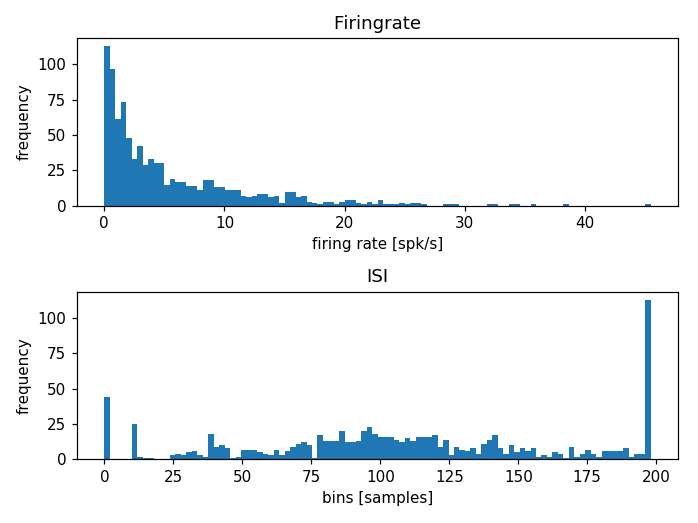

In [28]:
fig, ax = plt.subplots(2)
ax[0].hist(features[:, 0], bins=100)
ax[1].hist(features[:, 1], bins=100)
ax[0].set(title='Firingrate', xlabel='firing rate [spk/s]', ylabel='frequency')
ax[1].set(title='ISI', xlabel='bins [samples]', ylabel='frequency')
fig.tight_layout()
fig.savefig('{}histogram_{}.png'.format(fig_path, exp_name))

## Clustermap of ISI

<IPython.core.display.Javascript object>


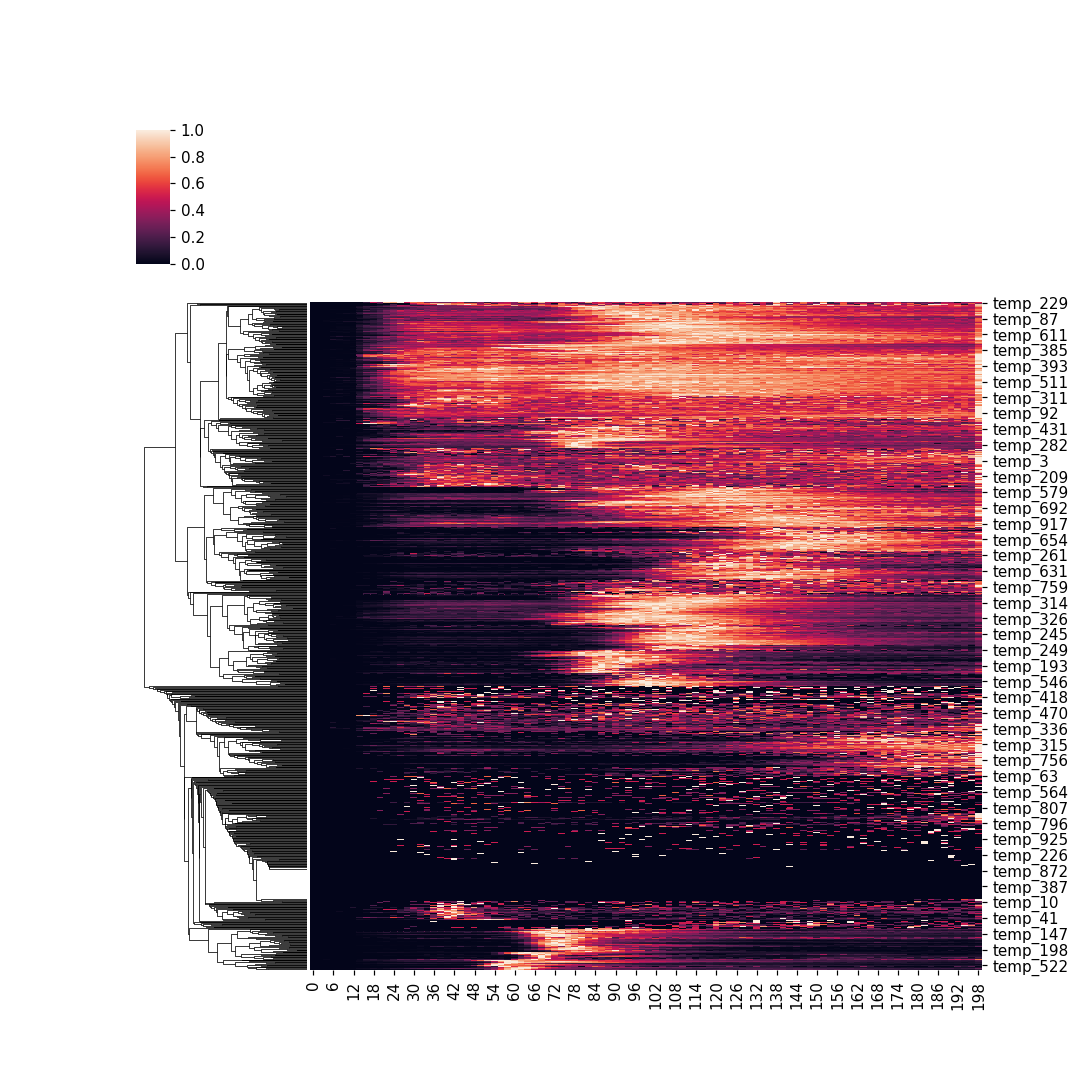

In [33]:
isi_max = isi.max(axis=1, )
isi_max[isi_max==0] = 1

g = sns.clustermap(isi/isi_max[:, None], col_cluster=False, figsize=(10, 10))
g.savefig('{}clustermap_{}.png'.format(fig_path, exp_name))

## Raster plot for a range of units

<IPython.core.display.Javascript object>


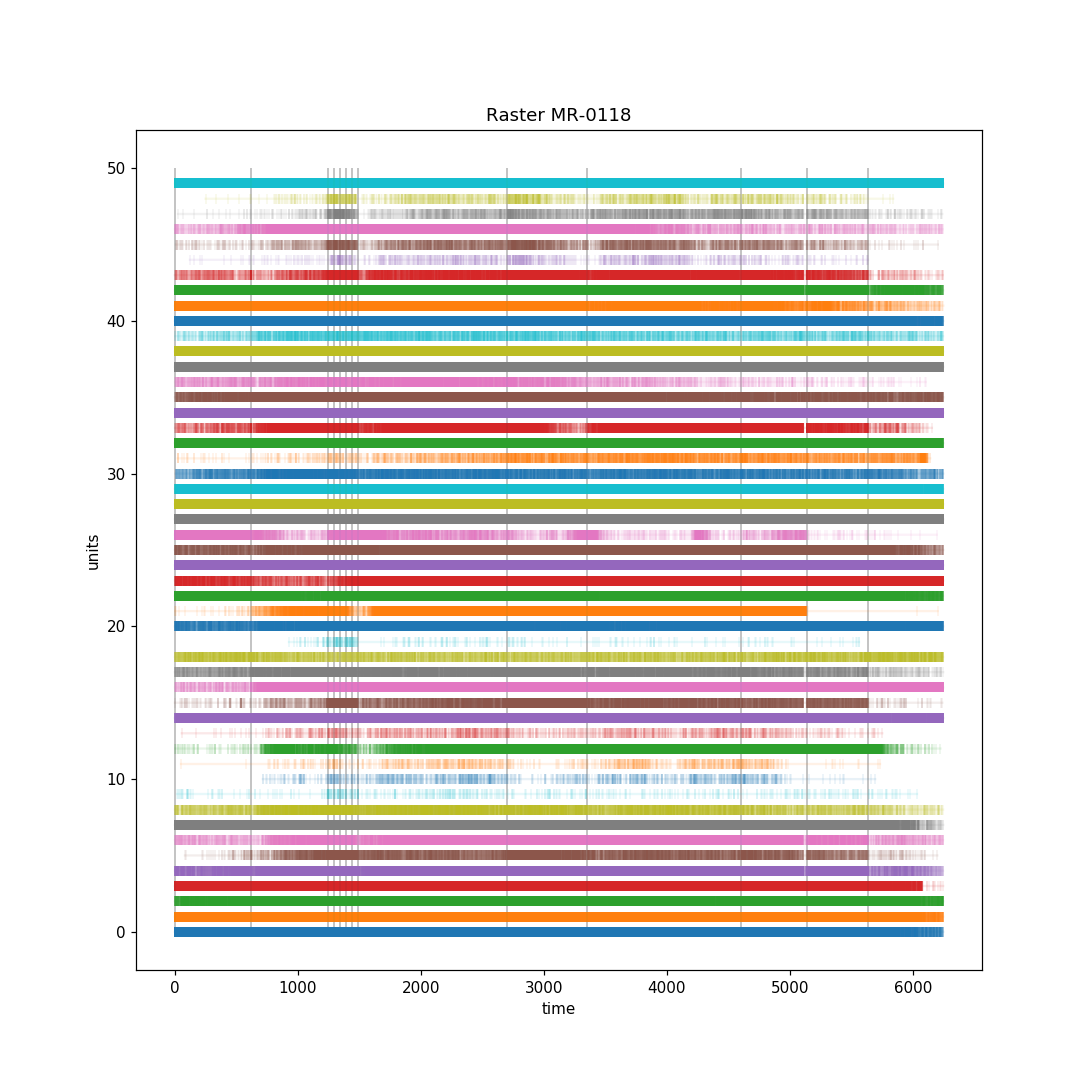

In [30]:
with h5py.File(sorting_path, 'r') as f:
#     fig, ax = plot_raster(sorting=f, idx_units=range(100,120), protocols_points=None)
#     fig, ax = plot_raster(sorting=f, range_view=(200, 250), protocols_points=None)
    fig, ax = plot_raster(
        sorting=f,
        range_view=(200, 250),
        protocols_points=start_ponit,
        figsize=(10, 10),
    )
    ax.set(title='Raster {}'.format(exp_name))
    fig.savefig('{}rasterplot_{}.png'.format(fig_path, exp_name))